In [ ]:
%pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 50.4 MB/s eta 0:00:00


Step 1: PGM Model
PGM - R^2: 0.72, MSE: 0.48, Accuracy: 0.65


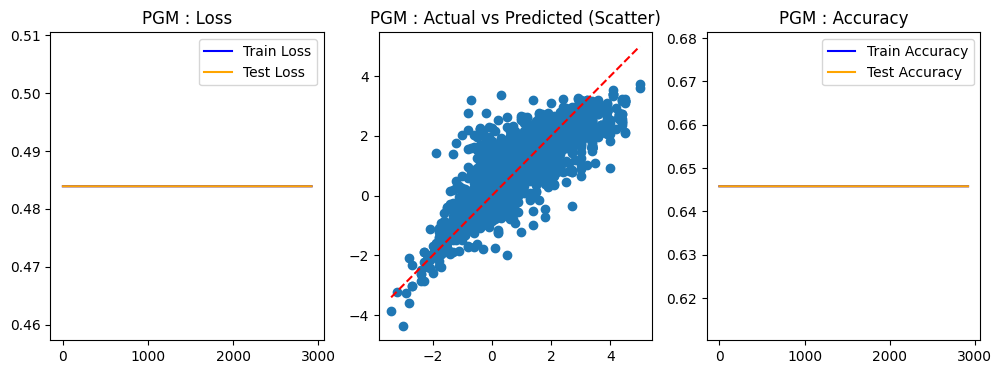

Step 2: GNN Model
Epoch 100/500, Loss: 0.3773, Accuracy: 0.7092
Epoch 200/500, Loss: 0.3350, Accuracy: 0.7353
Epoch 300/500, Loss: 0.3148, Accuracy: 0.7403
Epoch 400/500, Loss: 0.3000, Accuracy: 0.7487
Epoch 500/500, Loss: 0.2891, Accuracy: 0.7611
GNN - R^2: 0.82, MSE: 0.32, Accuracy: 0.75


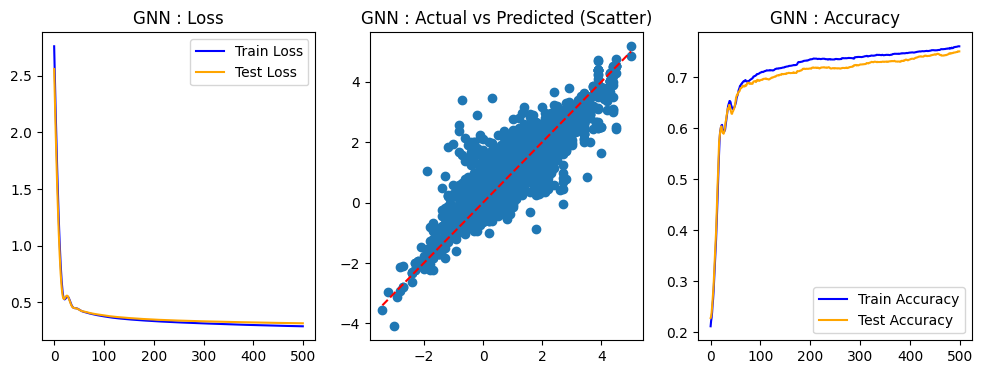

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 0.3783, Accuracy: 0.7166
Epoch 200/500, Loss: 0.3367, Accuracy: 0.7304
Epoch 300/500, Loss: 0.3110, Accuracy: 0.7501
Epoch 400/500, Loss: 0.2949, Accuracy: 0.7548
Epoch 500/500, Loss: 0.2813, Accuracy: 0.7672
GNN Combined - R^2: 0.82, MSE: 0.31, Accuracy: 0.75


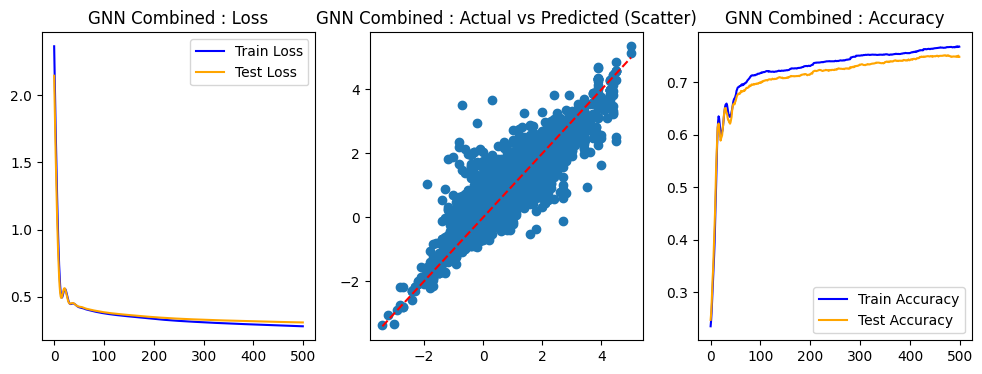

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Load the logp_synthetic data
data = pd.read_csv('logP_synthetic_dataset.csv', header=None, names=['SMILES', 'logP'])

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1)  # return a zero vector if SMILES is invalid
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)  # LogP of the molecule
    ]
    return descriptors

# Apply descriptor computation to the SMILES column
X = np.array([compute_descriptors(smiles) for smiles in data['SMILES']])

# The target variable (logP)
y = data['logP'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an accuracy threshold for regression
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)


Step 1: PGM Model
PGM - R^2: 0.74, MSE: 1.23, Accuracy: 0.38


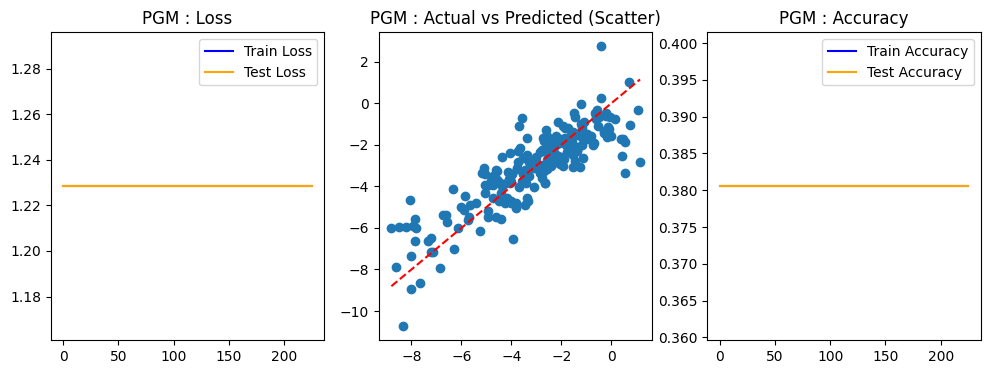

Step 2: GNN Model
Epoch 100/500, Loss: 0.8036, Accuracy: 0.4357
Epoch 200/500, Loss: 0.5134, Accuracy: 0.5698
Epoch 300/500, Loss: 0.4469, Accuracy: 0.5998
Epoch 400/500, Loss: 0.4068, Accuracy: 0.6353
Epoch 500/500, Loss: 0.3785, Accuracy: 0.6463
GNN - R^2: 0.84, MSE: 0.76, Accuracy: 0.56


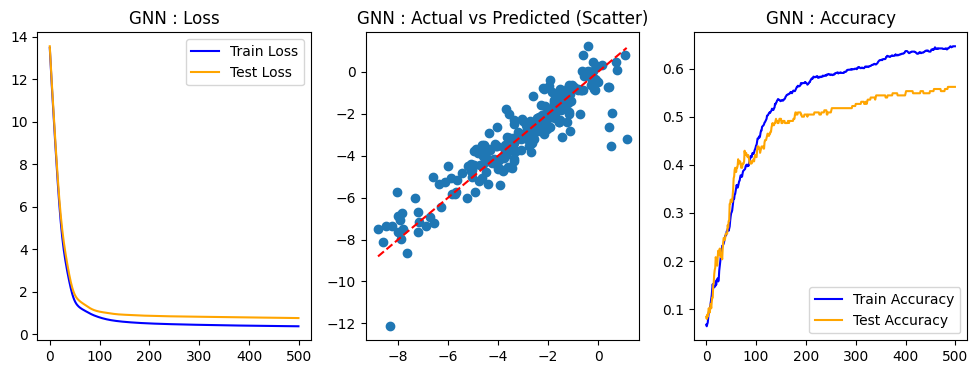

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 0.6614, Accuracy: 0.4933
Epoch 200/500, Loss: 0.4756, Accuracy: 0.5754
Epoch 300/500, Loss: 0.3878, Accuracy: 0.6275
Epoch 400/500, Loss: 0.3272, Accuracy: 0.6641
Epoch 500/500, Loss: 0.2799, Accuracy: 0.6962
GNN Combined - R^2: 0.86, MSE: 0.67, Accuracy: 0.60


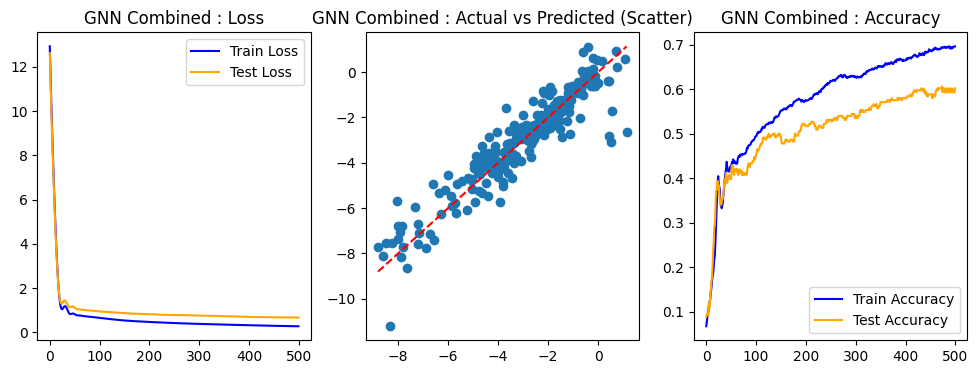

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Charger les données en tenant compte de l'entête
data = pd.read_csv('delaney-processed.csv')

# Convertir la colonne 'exp' en numérique (et gérer les erreurs)
data['measured log solubility in mols per litre'] = pd.to_numeric(data['measured log solubility in mols per litre'], errors='coerce')

# Filtrer les valeurs NaN qui auraient pu être introduites
data = data.dropna(subset=['measured log solubility in mols per litre'])

# Vérifier la présence de SMILES valides
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Fonction pour calculer les descripteurs moléculaires
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Retourner un vecteur de zéros en cas d'erreur
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Application de la fonction sur les SMILES valides
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['measured log solubility in mols per litre'].values

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définition d'un seuil de précision pour l'évaluation
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)


Step 1: PGM Model
PGM - R^2: 0.78, MSE: 3.56, Accuracy: 0.18


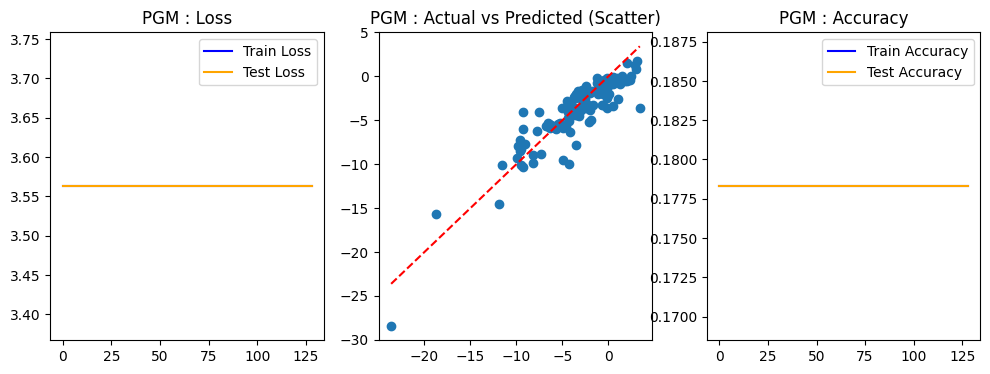

Step 2: GNN Model
Epoch 100/500, Loss: 3.7822, Accuracy: 0.2768
Epoch 200/500, Loss: 2.2867, Accuracy: 0.3002
Epoch 300/500, Loss: 1.8155, Accuracy: 0.3450
Epoch 400/500, Loss: 1.5487, Accuracy: 0.3860
Epoch 500/500, Loss: 1.3641, Accuracy: 0.4133
GNN - R^2: 0.91, MSE: 1.47, Accuracy: 0.38


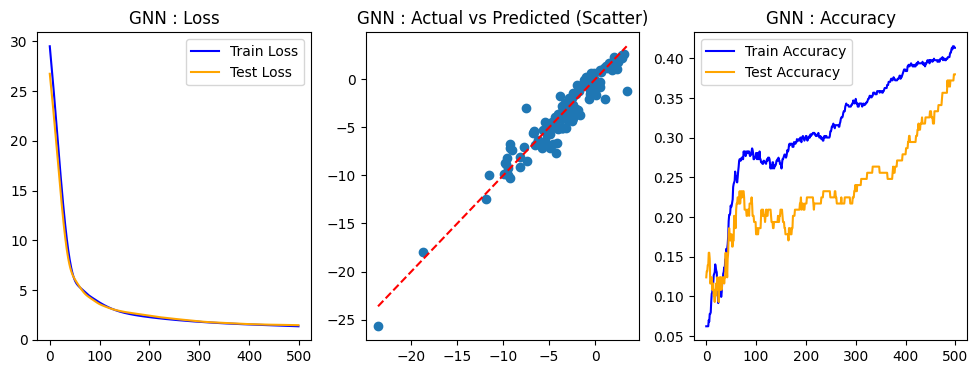

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 2.8289, Accuracy: 0.2963
Epoch 200/500, Loss: 2.0530, Accuracy: 0.3411
Epoch 300/500, Loss: 1.6158, Accuracy: 0.4230
Epoch 400/500, Loss: 1.4278, Accuracy: 0.4639
Epoch 500/500, Loss: 1.2900, Accuracy: 0.4932
GNN Combined - R^2: 0.90, MSE: 1.58, Accuracy: 0.41


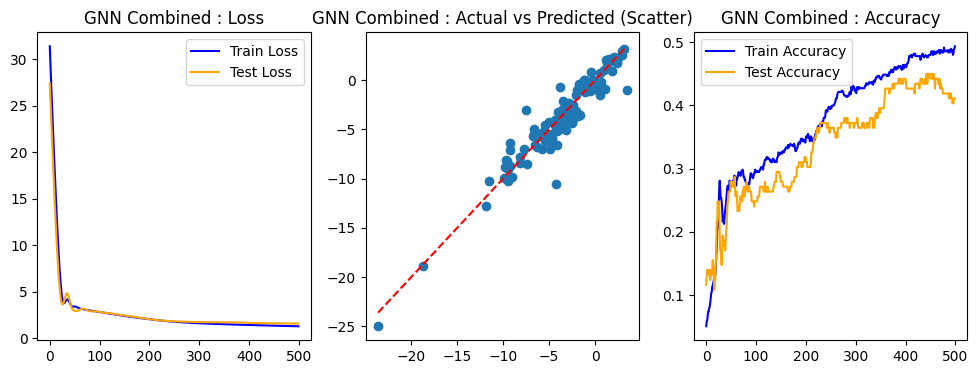

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Charger les données en tenant compte de l'entête
data = pd.read_csv('SAMPL.csv')

# Convertir la colonne 'exp' en numérique (et gérer les erreurs)
data['expt'] = pd.to_numeric(data['expt'], errors='coerce')

# Filtrer les valeurs NaN qui auraient pu être introduites
data = data.dropna(subset=['expt'])

# Vérifier la présence de SMILES valides
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Fonction pour calculer les descripteurs moléculaires
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Retourner un vecteur de zéros en cas d'erreur
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Application de la fonction sur les SMILES valides
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['expt'].values

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définition d'un seuil de précision pour l'évaluation
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)


Step 1: PGM Model
PGM - R^2: 0.74, MSE: 4.72, Accuracy: 0.21


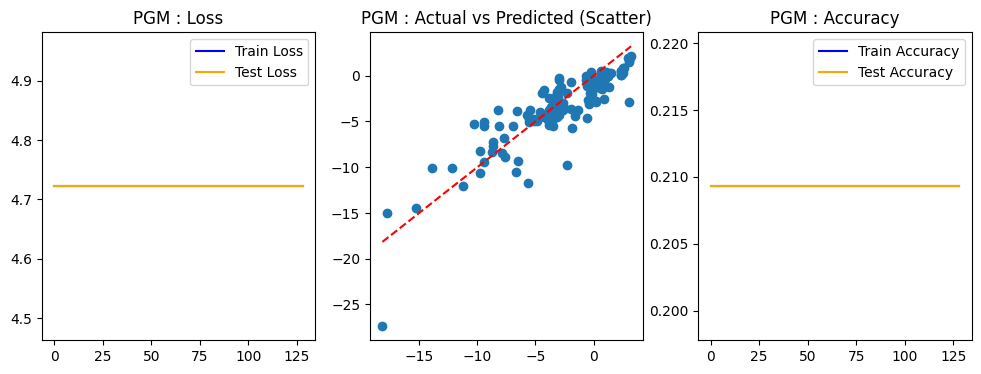

Step 2: GNN Model
Epoch 100/500, Loss: 4.7836, Accuracy: 0.2242
Epoch 200/500, Loss: 2.7395, Accuracy: 0.3041
Epoch 300/500, Loss: 1.9230, Accuracy: 0.3509
Epoch 400/500, Loss: 1.5847, Accuracy: 0.4016
Epoch 500/500, Loss: 1.3448, Accuracy: 0.4308
GNN - R^2: 0.90, MSE: 1.87, Accuracy: 0.38


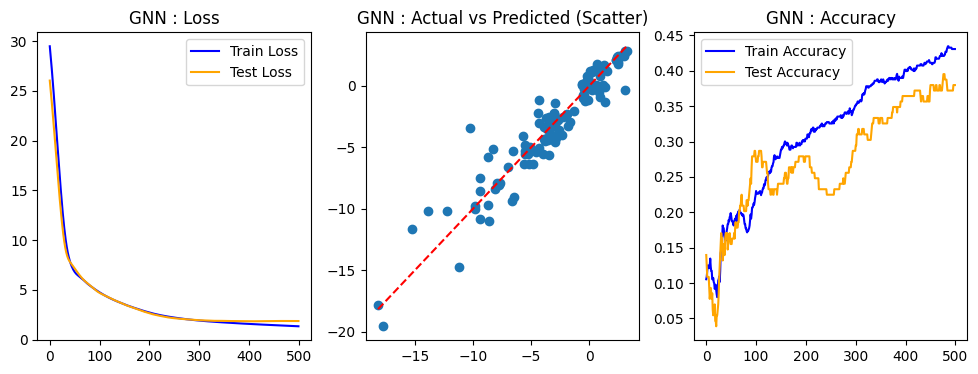

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 4.1025, Accuracy: 0.2710
Epoch 200/500, Loss: 2.6510, Accuracy: 0.3860
Epoch 300/500, Loss: 1.6914, Accuracy: 0.4483
Epoch 400/500, Loss: 1.3191, Accuracy: 0.4912
Epoch 500/500, Loss: 1.0629, Accuracy: 0.5341
GNN Combined - R^2: 0.89, MSE: 1.93, Accuracy: 0.42


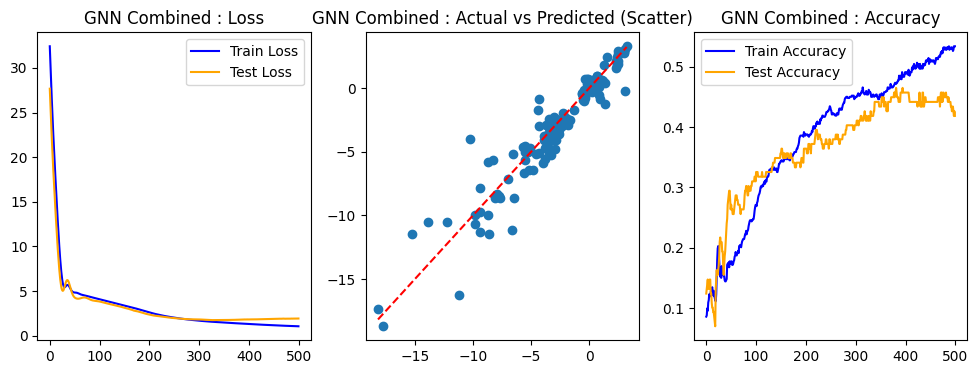

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Charger les données en tenant compte de l'entête
data = pd.read_csv('SAMPL.csv')

# Convertir la colonne 'exp' en numérique (et gérer les erreurs)
data['calc'] = pd.to_numeric(data['calc'], errors='coerce')

# Filtrer les valeurs NaN qui auraient pu être introduites
data = data.dropna(subset=['calc'])

# Vérifier la présence de SMILES valides
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Fonction pour calculer les descripteurs moléculaires
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Retourner un vecteur de zéros en cas d'erreur
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Application de la fonction sur les SMILES valides
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['calc'].values

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définition d'un seuil de précision pour l'évaluation
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)


Step 1: PGM Model
PGM - R^2: 0.23, MSE: 1.14, Accuracy: 0.38


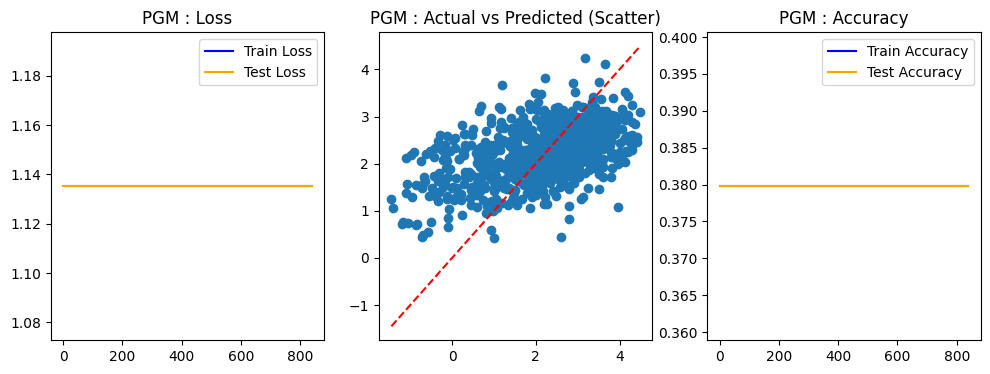

Step 2: GNN Model
Epoch 100/500, Loss: 1.0519, Accuracy: 0.3509
Epoch 200/500, Loss: 0.9514, Accuracy: 0.3863
Epoch 300/500, Loss: 0.8931, Accuracy: 0.4083
Epoch 400/500, Loss: 0.8523, Accuracy: 0.4185
Epoch 500/500, Loss: 0.8134, Accuracy: 0.4342
GNN - R^2: 0.39, MSE: 0.91, Accuracy: 0.43


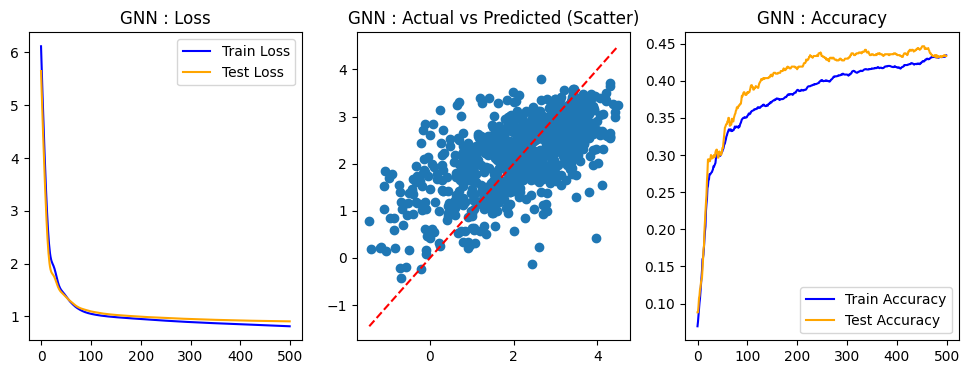

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 1.0078, Accuracy: 0.3628
Epoch 200/500, Loss: 0.9331, Accuracy: 0.3964
Epoch 300/500, Loss: 0.8616, Accuracy: 0.4149
Epoch 400/500, Loss: 0.7908, Accuracy: 0.4357
Epoch 500/500, Loss: 0.7308, Accuracy: 0.4565
GNN Combined - R^2: 0.39, MSE: 0.91, Accuracy: 0.45


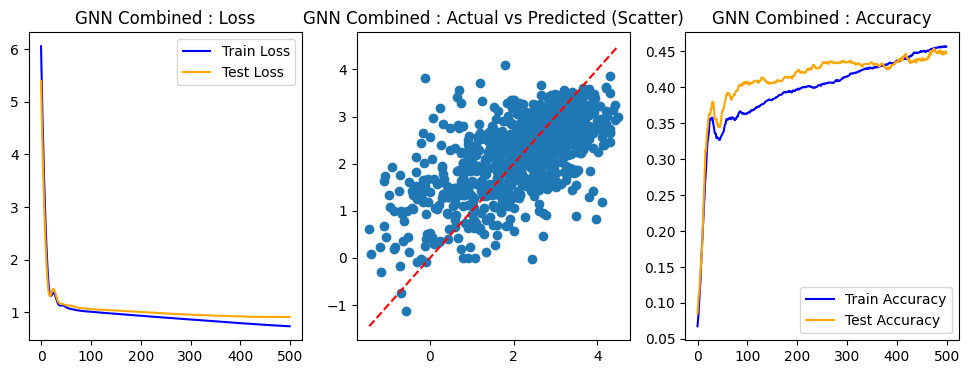

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Charger les données en tenant compte de l'entête
data = pd.read_csv('Lipophilicity.csv')

# Convertir la colonne 'exp' en numérique (et gérer les erreurs)
data['exp'] = pd.to_numeric(data['exp'], errors='coerce')

# Filtrer les valeurs NaN qui auraient pu être introduites
data = data.dropna(subset=['exp'])

# Vérifier la présence de SMILES valides
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Fonction pour calculer les descripteurs moléculaires
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Retourner un vecteur de zéros en cas d'erreur
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Application de la fonction sur les SMILES valides
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['exp'].values

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définition d'un seuil de précision pour l'évaluation
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)
